# Investigation

I have fairly successfully replicated and extended the notebook with the first investigation notebook. In this one, I want to add the ability to predict a candle close further forward in time. ie. x + n candles instead of just x + 1.

### Note

In this repo I am using a custom module `malfoy.metatrader` that I built on top of the `MetaTrader5` package. This interfaces directly with MetaTrader to pull up-to-date data. I hope to eventually make this open-source but for now it's a private module. I have also saved the data used in `./data/new` so it can be reused.

In [107]:
# Import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib widget

In [108]:
# Functions

def CreateScaler(data: pd.Series) -> MinMaxScaler:
  data = np.array(data).reshape(-1, 1)
  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(data)

  return scaler

def GetScaledData(data: pd.Series, scaler: MinMaxScaler) -> pd.Series:
  data = np.array(data).reshape(-1, 1)
  return scaler.transform(data)

def GetTimeStepDataFrame(data: pd.DataFrame, lookbackTimeSteps: int, predictionTimeSteps: int, trainingColumns: list, predictionColumn: str) -> pd.DataFrame:
  timeStepData = pd.DataFrame(index=data.index)

  for column in trainingColumns:
    for i in range(predictionTimeSteps, (lookbackTimeSteps + predictionTimeSteps) + 1):
      newColName = "{0}_{1}".format(column, i)
      timeStepData[newColName] = data[column].shift(i)

  timeStepData[predictionColumn] = data[predictionColumn]
  
  timeStepData = timeStepData.dropna()

  return timeStepData

## Variables

These core variables are used throughout the scripts. The instrument and granularity variables can be used to change the target of predictions. These correspond to the data found in `./data/new/`

*Prediction Variables*:
- instrument - the instrument being predicted
- granularity - the timeframe being predicted on (One minute, one hour, one day, etc)
- lookbackTimeSteps - the number of previous time steps to use in making the prediction for the current candle
- predictionColumn - the column from the dataframe we are trying to predict

In [109]:
# Set script variables
seedValue = 72
trainingSizePercent = 0.7
inputDataFolder = "./input/new"

# Change these for prediction changes
instrument = "BTCUSD"
granularity = "M5"
lookbackTimeSteps = 15
predictionTimeSteps = 10
predictionColumn = "midCloseDelta"
trainingColumns = ["midClose", "midCloseDelta"]

In [110]:
# Import data

rawDataFilePath = "{0}/{1}_{2}.csv".format(inputDataFolder, instrument, granularity)
rawData = pd.read_csv(rawDataFilePath)

rawData

,Unnamed: 0,instrument,granularity,time,stringTime,volume,bidOpen,bidHigh,bidLow,bidClose,midOpen,midHigh,midLow,midClose,askOpen,askHigh,askLow,askClose
0,0,BTCUSD,M5,2022-04-03 02:55:00,2022-04-03T02:55:00,972,45857.50,45872.5,45779.50,45813.50,45857.50,45872.5,45779.50,45813.50,45857.50,45872.5,45779.50,45813.50
1,1,BTCUSD,M5,2022-04-03 03:00:00,2022-04-03T03:00:00,824,45813.50,45877.5,45778.50,45869.08,45813.50,45877.5,45778.50,45869.08,45813.50,45877.5,45778.50,45869.08
2,2,BTCUSD,M5,2022-04-03 03:05:00,2022-04-03T03:05:00,1060,45869.08,45977.5,45819.03,45931.50,45869.08,45977.5,45819.03,45931.50,45869.08,45977.5,45819.03,45931.50
3,3,BTCUSD,M5,2022-04-03 03:10:00,2022-04-03T03:10:00,1106,45932.00,45946.5,45880.85,45938.00,45932.00,45946.5,45880.85,45938.00,45932.00,45946.5,45880.85,45938.00
4,4,BTCUSD,M5,2022-04-03 03:15:00,2022-04-03T03:15:00,979,45940.50,45949.5,45898.00,45948.50,45940.50,45949.5,45898.00,45948.50,45940.50,45949.5,45898.00,45948.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,BTCUSD,M5,2022-04-20 11:40:00,2022-04-20T11:40:00,668,41431.00,41520.0,41430.39,41475.50,41431.00,41520.0,41430.39,41475.50,41431.00,41520.0,41430.39,41475.50
4996,4996,BTCUSD,M5,2022-04-20 11:45:00,2022-04-20T11:45:00,730,41473.30,41488.5,41433.56,41465.50,41473.30,41488.5,41433.56,41465.50,41473.30,41488.5,41433.56,41465.50
4997,4997,BTCUSD,M5,2022-04-20 11:50:00,2022-04-20T11:50:00,489,41465.50,41484.0,41448.50,41448.50,41465.50,41484.0,41448.50,41448.50,41465.50,41484.0,41448.50,41448.50
4998,4998,BTCUSD,M5,2022-04-20 11:55:00,2022-04-20T11:55:00,637,41448.50,41486.5,41446.50,41476.50,41448.50,41486.5,41446.50,41476.50,41448.50,41486.5,41446.50,41476.50


In [111]:
# Pre-process data

ppData = rawData.copy()

# New columns
ppData["askCloseDelta"] = ppData["askClose"] - ppData["askClose"].shift(predictionTimeSteps)
ppData["midCloseDelta"] = ppData["midClose"] - ppData["midClose"].shift(predictionTimeSteps)
ppData["bidCloseDelta"] = ppData["bidClose"] - ppData["bidClose"].shift(predictionTimeSteps)

# Split data in to test and train
trainingEntryCount = math.floor(len(ppData) * trainingSizePercent)
trainingData = ppData.iloc[0:trainingEntryCount, :]
testData = ppData.iloc[trainingEntryCount:len(ppData), :]

# Scale required columns
scaledColumns = ["bidOpen", "bidHigh", "bidLow", "midOpen", "midHigh", "midLow", "askOpen", "askHigh", "askLow", "volume", "bidClose", "midClose", "askClose", "midCloseDelta"]

scalerDict = {}

for column in scaledColumns:
  scalerDict[column] = CreateScaler(trainingData[column])
  
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
  testData[column] = GetScaledData(testData[column], scalerDict[column])

# Add previous time steps as data available for making prediction
trainingTimeStepData = GetTimeStepDataFrame(trainingData, lookbackTimeSteps=lookbackTimeSteps, predictionTimeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_trainingData = trainingTimeStepData.drop(columns=predictionColumn)
Y_trainingData = trainingTimeStepData[predictionColumn]

testTimeStepData = GetTimeStepDataFrame(testData, lookbackTimeSteps=lookbackTimeSteps, predictionTimeSteps=predictionTimeSteps, trainingColumns=trainingColumns, predictionColumn=predictionColumn)
X_testData = testTimeStepData.drop(columns=predictionColumn)
Y_testData = testTimeStepData[predictionColumn]

print("X_trainingData shape:", X_trainingData.shape)
print("Y_trainingData shape:", Y_trainingData.shape)
print("X_testData shape:", X_testData.shape)
print("Y_testData shape:", Y_testData.shape)

X_trainingData.to_csv("./train.csv")
trainingData.to_csv("./train_raw.csv")
X_testData.to_csv("./test.csv")
testData.to_csv("./test_raw.csv")

C:\Users\sambe\AppData\Local\Temp\ipykernel_25280\2956124020.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainingData[column] = GetScaledData(trainingData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_25280\2956124020.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testData[column] = GetScaledData(testData[column], scalerDict[column])
C:\Users\sambe\AppData\Local\Temp\ipykernel_25280\2956124020.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

X_trainingData shape: (3465, 32)
Y_trainingData shape: (3465,)
X_testData shape: (1475, 32)
Y_testData shape: (1475,)


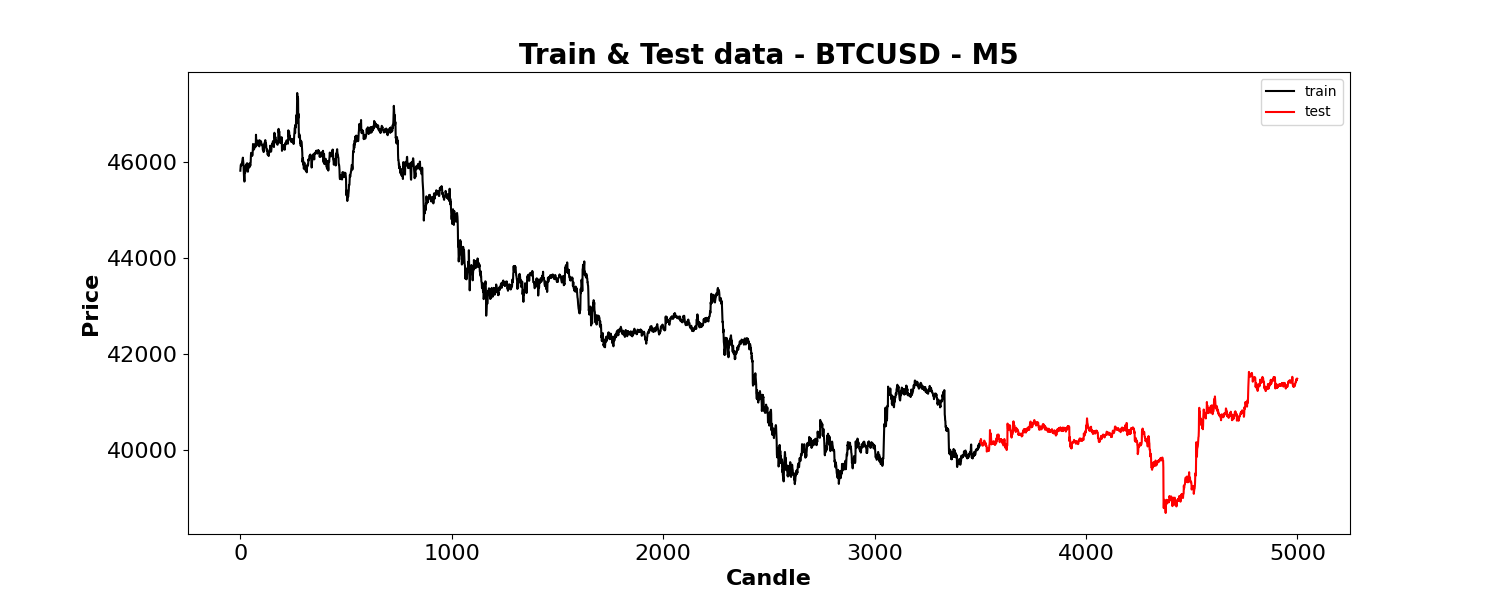

In [112]:
# Plot test and train data

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')

# Formatting
ax.set_title('Train & Test data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))

In [113]:
# Train model

model = XGBRegressor(n_estimators=10000, seed=seedValue)
model.fit(X_trainingData, Y_trainingData, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=72,
             reg_alpha=0, reg_lambda=1, ...)

In [114]:
# Model testing and evaluation

predictions = model.predict(X_testData)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(Y_testData, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(Y_testData, predictions))))

Mean Absolute Error - MAE : 0.0657408254498163
Root Mean squared Error - RMSE : 0.09614770456679021


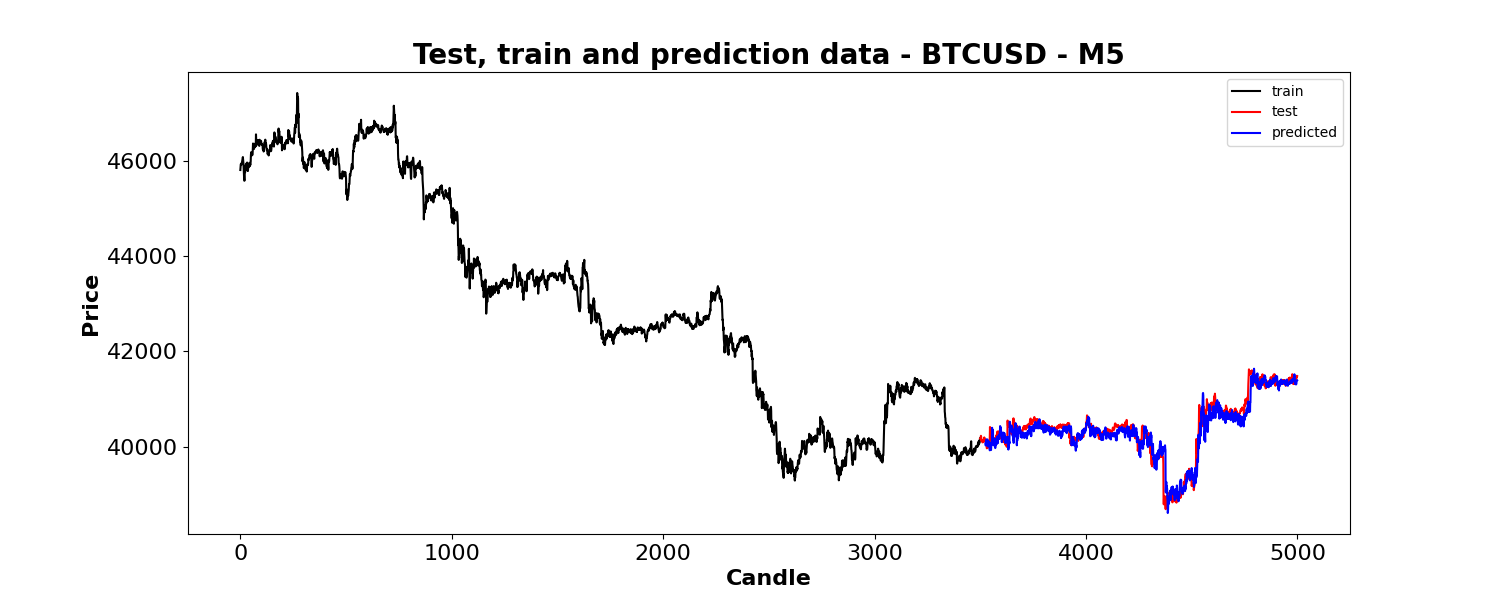

In [115]:
# Plot the predicted vs actual
plotTestData = X_testData.copy()

plotTestData["midClose"] = testData["midClose"]
plotTestData["midClose"] = scalerDict["midClose"].inverse_transform(np.array(plotTestData["midClose"]).reshape(-1, 1))
plotTestData["PredictedValue"] = scalerDict[predictionColumn].inverse_transform(np.array(predictions).reshape(-1, 1))
plotTestData["PredictedCloseDelta"] = plotTestData["PredictedValue"]
plotTestData["PredictedValue"] = plotTestData["PredictedValue"] + plotTestData["midClose"]

plotTestData.to_csv("./predictions.csv")

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = rawData.index[:trainingEntryCount], y = rawData['midClose'][:trainingEntryCount], color = 'black')
sns.lineplot(x = rawData.index[trainingEntryCount:], y = rawData['midClose'][trainingEntryCount:], color = 'red')
sns.lineplot(x = plotTestData.index, y = plotTestData['PredictedValue'], color = 'blue')

# Formatting
ax.set_title('Test, train and prediction data - {0} - {1}'.format(instrument, granularity), fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Candle', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test', "predicted"))
